# Proyecto Machine Learning - Clasificacion de imagenes
# -- Clasificacion si una persona porta o no mascarilla --
## Grupo: 6CV3
## Integrantes:
* Pérez Mongragón Eduardo
* Rosiles Hidalgo Emanuel

# ResNet50

In [10]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [ ]:
def redimencionar_imagenes(dataset_path, target_size, nombre_clase, nombre_carpeta):
    resized_path = os.path.join(dataset_path, nombre_carpeta)
    os.makedirs(resized_path, exist_ok=True)

    original_path = os.path.join(dataset_path, nombre_clase)

    file_list = os.listdir(original_path)

    # Itera sobre los archivos de cada imagen y redimensiona cada una
    for file_name in file_list:
        original_image_path = os.path.join(original_path, file_name)
        image = Image.open(original_image_path)
        resized_image = image.resize(target_size)
        resized_image_path = os.path.join(resized_path, file_name)
        resized_image.save(resized_image_path)

# ------------------------------ Solo correr la primera vez ------------------------------

dataset_path_train = "./Train"

# Parámetros de preprocesamiento de imágenes
img_size = (64, 64)
batch_size = 32

redimencionar_imagenes(dataset_path_train, img_size, "WithMask", "WithMask_resize") 
redimencionar_imagenes(dataset_path_train, img_size, "WithoutMask", "WithoutMask_resize") 

# Aplicación del Hold_Out en el banco de imágenes

In [12]:
# Rutas de los directorios de las imágenes de cada clase
directorio_clase_1 = './Train/WithMask'
directorio_clase_2 = './Train/WithoutMask'

# Lista para almacenar las imágenes y las etiquetas
imagenes = []
etiquetas = []

# Recorrer el directorio de la clase 1 y cargar las imágenes
for archivo in os.listdir(directorio_clase_1):
    ruta_imagen = os.path.join(directorio_clase_1, archivo)
    imagen = load_img(ruta_imagen, target_size=(64, 64))
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(0)  # Etiqueta para la clase 1

# Recorrer el directorio de la clase 2 y cargar las imágenes
for archivo in os.listdir(directorio_clase_2):
    ruta_imagen = os.path.join(directorio_clase_2, archivo)
    imagen = load_img(ruta_imagen, target_size=(64, 64))
    imagen = img_to_array(imagen)
    imagenes.append(imagen)
    etiquetas.append(1)  # Etiqueta para la clase 2

# Convertir las listas a arreglos numpy
imagenes = np.array(imagenes)
etiquetas = np.array(etiquetas)
etiquetas = to_categorical(etiquetas, num_classes=2)


In [13]:
# Aplicacion de hold out al banco de datos
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
# Verificar el tamaño de las imagenes
image_size = X_train.shape[1:3]
print("Tamaño de las imágenes:", image_size)

Tamaño de las imágenes: (64, 64)


In [15]:
# Normalizacion de los valores de los pixeles
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255) 
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Aplicacion de normalizacion y division por lotes de los distintos conjuntos de imagenes
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

print(f'Entrenamiento: {train_generator.n}')
print(f'Validación: {val_generator.n}')
print(f'Prueba: {test_generator.n}')

Entrenamiento: 6400
Validación: 1600
Prueba: 2000


# Definición del modelo

In [16]:
# Cargar el modelo ResNet-50 preentrenado sin incluir las capas superiores
resnet50 = ResNet50(classes= 2, weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Congelar las capas preentrenadas del modelo base
for layer in resnet50.layers:
    layer.trainable = False

# Agregar capa flatten
x = Flatten()(resnet50.output)

# Agregar capa para clasificacion
prediction = Dense( 2 , activation = 'softmax' )(x)

# Unir capas a la salida del modelo
model = Model( inputs = resnet50.input , outputs = prediction )

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Guardar pesos iniciales para reutilizar el modelo
pesos_iniciales = model.get_weights()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 16, 16, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 16, 16, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 16, 16, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 8, 8, 128)   0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 8, 8, 512)    66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 4, 4, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 4, 4, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 4, 4, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 2, 2, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 2, 2, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 2, 2, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

# Entrenamiento con 10 épocas

In [17]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

model.save("modelo_64x64_10Epocs_HoldOut_ResNet50.h5")

Epoch 1/10
200/200 [==============================] - 65s 305ms/step - loss: 0.6295 - accuracy: 0.6589 - val_loss: 0.6235 - val_accuracy: 0.6094
Epoch 2/10
200/200 [==============================] - 62s 312ms/step - loss: 0.5625 - accuracy: 0.7297 - val_loss: 0.5319 - val_accuracy: 0.7881
Epoch 3/10
200/200 [==============================] - 61s 305ms/step - loss: 0.5101 - accuracy: 0.7789 - val_loss: 0.4869 - val_accuracy: 0.8131
Epoch 4/10
200/200 [==============================] - 55s 273ms/step - loss: 0.4801 - accuracy: 0.8055 - val_loss: 0.4696 - val_accuracy: 0.8194
Epoch 5/10
200/200 [==============================] - 55s 273ms/step - loss: 0.4529 - accuracy: 0.8222 - val_loss: 0.4579 - val_accuracy: 0.7856
Epoch 6/10
200/200 [==============================] - 60s 299ms/step - loss: 0.4345 - accuracy: 0.8258 - val_loss: 0.4260 - val_accuracy: 0.8175
Epoch 7/10
200/200 [==============================] - 63s 315ms/step - loss: 0.4208 - accuracy: 0.8322 - val_loss: 0.4050 - val_ac

# Métricas

63/63 [==============================] - 14s 214ms/step


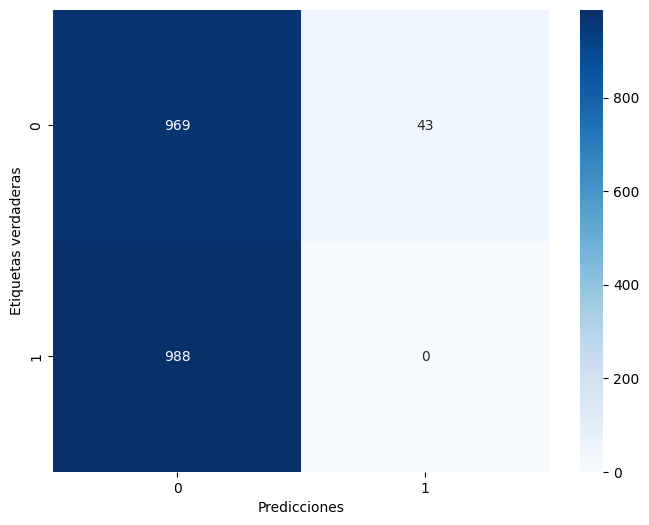

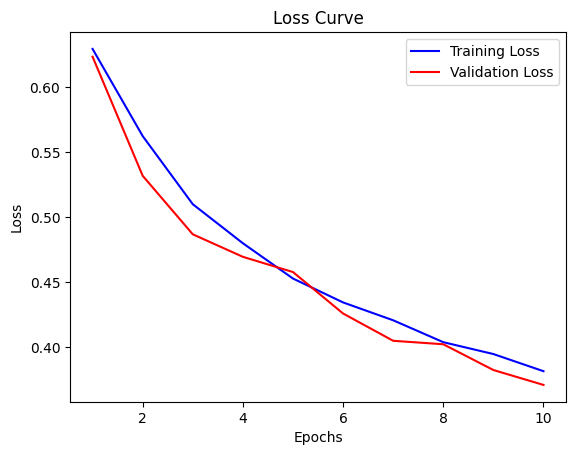

In [18]:
# Evaluar el modelo en los datos de prueba
model = load_model("modelo_64x64_10Epocs_HoldOut_ResNet50.h5")

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 14s 213ms/step - loss: 0.3860 - accuracy: 0.8485
Test: accuracy = 0.848500  ;  loss = 0.385981 


In [20]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.50      0.96      0.65      1012
 WithoutMask       0.00      0.00      0.00       988

    accuracy                           0.48      2000
   macro avg       0.25      0.48      0.33      2000
weighted avg       0.25      0.48      0.33      2000



# Entrenamiento con 30 épocas

In [60]:
#Reiniciar pesos en el modelo
model.set_weights(pesos_iniciales)

In [61]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

model.save("modelo_64x64_30Epocs_HoldOut_ResNet50.h5") #Guardar el modelo entrenado

Epoch 1/30
200/200 [==============================] - 56s 281ms/step - loss: 0.6210 - accuracy: 0.6630 - val_loss: 0.5493 - val_accuracy: 0.7638
Epoch 2/30
200/200 [==============================] - 57s 286ms/step - loss: 0.5315 - accuracy: 0.7663 - val_loss: 0.5068 - val_accuracy: 0.7563
Epoch 3/30
200/200 [==============================] - 57s 283ms/step - loss: 0.4835 - accuracy: 0.8017 - val_loss: 0.4626 - val_accuracy: 0.8094
Epoch 4/30
200/200 [==============================] - 62s 309ms/step - loss: 0.4600 - accuracy: 0.8084 - val_loss: 0.4441 - val_accuracy: 0.8081
Epoch 5/30
200/200 [==============================] - 57s 286ms/step - loss: 0.4339 - accuracy: 0.8277 - val_loss: 0.4164 - val_accuracy: 0.8388
Epoch 6/30
200/200 [==============================] - 56s 282ms/step - loss: 0.4160 - accuracy: 0.8341 - val_loss: 0.4026 - val_accuracy: 0.8394
Epoch 7/30
200/200 [==============================] - 56s 282ms/step - loss: 0.4070 - accuracy: 0.8363 - val_loss: 0.4539 - val_ac

# Métricas

63/63 [==============================] - 15s 228ms/step


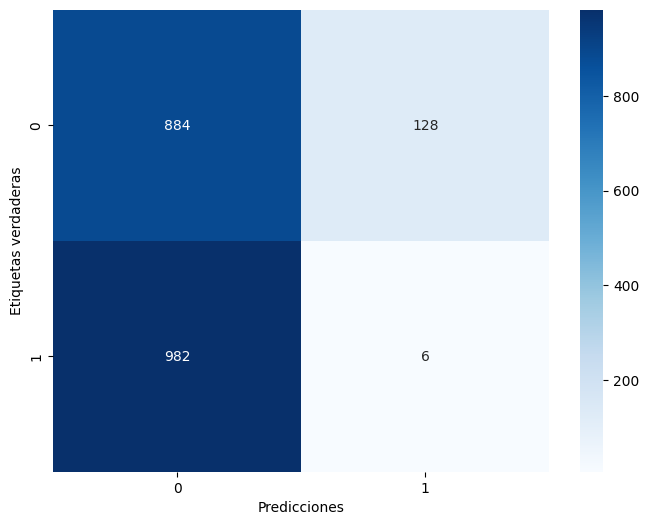

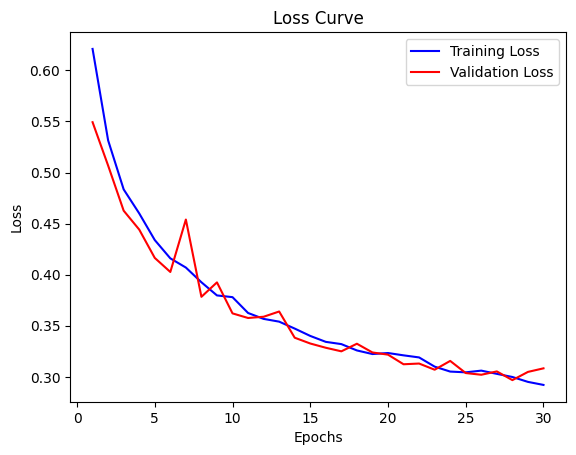

In [62]:
# Evaluar el modelo en los datos de prueba
model = load_model("modelo_64x64_30Epocs_HoldOut_ResNet50.h5")

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 15s 228ms/step - loss: 0.3347 - accuracy: 0.8520
Test: accuracy = 0.852000  ;  loss = 0.334718 


In [65]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.47      0.87      0.61      1012
 WithoutMask       0.04      0.01      0.01       988

    accuracy                           0.45      2000
   macro avg       0.26      0.44      0.31      2000
weighted avg       0.26      0.45      0.32      2000



# Entrenamiento con 50 épocas

In [67]:
#Reiniciar pesos en el modelo
model.set_weights(pesos_iniciales)

In [68]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

model.save("modelo_64x64_50Epocs_HoldOut_ResNet50.h5") #Guardar el modelo entrenado

Epoch 1/50
200/200 [==============================] - 60s 290ms/step - loss: 0.6225 - accuracy: 0.6598 - val_loss: 0.5462 - val_accuracy: 0.7738
Epoch 2/50
200/200 [==============================] - 56s 282ms/step - loss: 0.5280 - accuracy: 0.7622 - val_loss: 0.5002 - val_accuracy: 0.7663
Epoch 3/50
200/200 [==============================] - 56s 280ms/step - loss: 0.4901 - accuracy: 0.7894 - val_loss: 0.4680 - val_accuracy: 0.8231
Epoch 4/50
200/200 [==============================] - 56s 278ms/step - loss: 0.4590 - accuracy: 0.8119 - val_loss: 0.4344 - val_accuracy: 0.8413
Epoch 5/50
200/200 [==============================] - 56s 282ms/step - loss: 0.4328 - accuracy: 0.8269 - val_loss: 0.4206 - val_accuracy: 0.8419
Epoch 6/50
200/200 [==============================] - 56s 278ms/step - loss: 0.4153 - accuracy: 0.8339 - val_loss: 0.4009 - val_accuracy: 0.8425
Epoch 7/50
200/200 [==============================] - 61s 304ms/step - loss: 0.4042 - accuracy: 0.8397 - val_loss: 0.3963 - val_ac

# Métricas

63/63 [==============================] - 15s 226ms/step


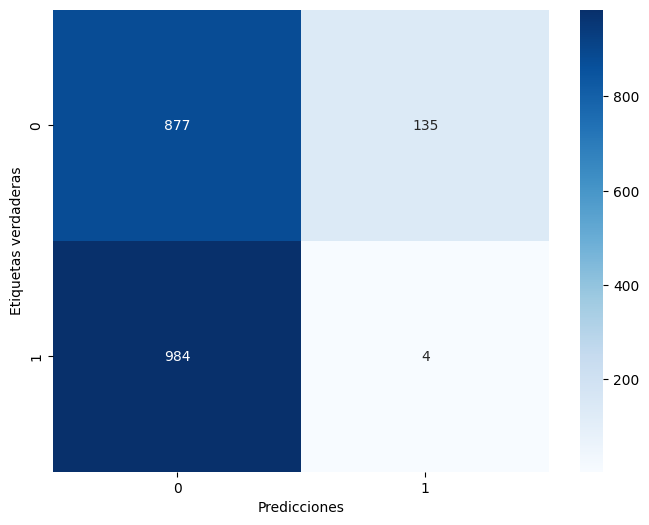

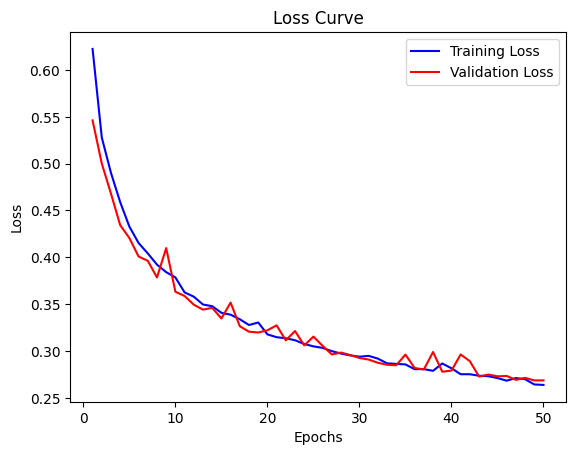

In [69]:
# Evaluar el modelo en los datos de prueba
model = load_model("modelo_64x64_50Epocs_HoldOut_ResNet50.h5")

# Obtener predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()

# Obtener valores de pérdida
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráfico de la curva de pérdida
plt.plot(range(1, len(train_loss) + 1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, 'r', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
loss, accuracy = model.evaluate(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

63/63 [==============================] - 15s 218ms/step - loss: 0.2936 - accuracy: 0.8720
Test: accuracy = 0.872000  ;  loss = 0.293570 


In [71]:
report = classification_report(y_true, y_pred_classes, target_names=['WithMask','WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       0.47      0.87      0.61      1012
 WithoutMask       0.03      0.00      0.01       988

    accuracy                           0.44      2000
   macro avg       0.25      0.44      0.31      2000
weighted avg       0.25      0.44      0.31      2000



# Pruebas

# 10 épocas

In [21]:
model = load_model("modelo_64x64_10Epocs_HoldOut_ResNet50.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 50ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithMask
Etiqueta predicha

# 30 épocas

In [22]:
model = load_model("modelo_64x64_30Epocs_HoldOut_ResNet50.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 44ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithMask
Etiqueta predicha

# 50 épocas

In [23]:
model = load_model("modelo_64x64_50Epocs_HoldOut_ResNet50.h5")
prueba_dir = "Prueba"

clases_etiquetas = {
    0: "WithMask",
    1: "WithoutMask",
}

# Lista para almacenar los nombres de archivo y las predicciones
predicciones = []

# Recorre los archivos en la carpeta de prueba
for filename in os.listdir(prueba_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Asegúrate de que solo se consideren archivos de imagen
        # Ruta completa de la imagen
        imagen_path = os.path.join(prueba_dir, filename)

        # Carga la imagen
        image = Image.open(imagen_path)
        image = image.convert("RGB")

        # Preprocesa la imagen
        image = image.resize((64, 64))
        image_array = np.array(image)
        image_array = image_array / 255.0
        input_array = np.expand_dims(image_array, axis=0)

        # Realiza la predicción
        prediction = model.predict(input_array)
        predicted_class = np.argmax(prediction)

        # Obtén la etiqueta correspondiente al número de clase
        clase_etiqueta = clases_etiquetas[predicted_class]

        # Guarda el nombre del archivo, la predicción y la etiqueta en la lista
        predicciones.append((filename, predicted_class, clase_etiqueta))

# Imprime las predicciones
for nombre_archivo, clase_predicha, etiqueta in predicciones:
    # Obtener la etiqueta verdadera del archivo
    if "Sin" in nombre_archivo:
        etiqueta_verdadera = "WithoutMask"
    elif "Con" in nombre_archivo:
        etiqueta_verdadera = "WithMask"
    else:
        etiqueta_verdadera = "Etiqueta desconocida"

    # Imprimir la etiqueta verdadera
    print("Etiqueta verdadera:", etiqueta_verdadera)
    print("Etiqueta predicha: ", etiqueta)
    print("Imagen: ", nombre_archivo)
    print()

1/1 [==============================] - 0s 62ms/step
Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  00_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  01_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  02_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  03_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  04_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  05_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  06_Sin.png

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  07_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  08_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  09_Sin.jpg

Etiqueta verdadera: WithoutMask
Etiqueta predicha:  WithMask
Imagen:  10_Sin.jpg

Etiqueta verdadera: WithMask
Etiqueta predicha